In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, brier_score_loss
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

In [4]:
data = pd.read_csv('data/model_data.csv')

# Modeling

Feature Selection

In [6]:
log_reg_df = data[['pitch_type', 'GameDate', 'pitcher', 'batter', 'ab', 'pitchnum', 
       'Count_0_1', 'Count_0_2', 'Count_2_1',
       'Count_1_0', 'Count_1_1', 'Count_1_2', 'Count_2_0', 'Count_2_2', 'Count_3_1',
       'Count_3_0', 'batter_count', 'pitcher_count']].copy()

log_reg_df['neutral_count'] = ((log_reg_df['batter_count'] == 0) & (log_reg_df['pitcher_count']== 0)).astype(int)

Player-Specific Features and train/test split

In [8]:
train = log_reg_df[log_reg_df['GameDate'] < '2023-06-15'] #~81% of data before this date

historical_rates = train.copy()

#calculation for naive model to compare
naive_historical_rates = historical_rates.groupby(['pitcher'])['pitch_type'].agg(['sum', 'count']).reset_index()
naive_historical_rates['naive_historical_rate'] = naive_historical_rates['sum'] / naive_historical_rates['count']
naive_historical_rates = naive_historical_rates.drop(['count', 'sum'], axis=1)

#Pitcher Fastball rate when up in count
pitcher_fb_rate_batter_count = historical_rates[historical_rates['batter_count'] == 1.0].groupby('pitcher')['pitch_type'].agg(['sum', 'count']).reset_index()
pitcher_fb_rate_batter_count['sum'] += 80/4 #beta binomial with B(80/4, 25) as prior (to pull rates closer to mean of 80%)
pitcher_fb_rate_batter_count['count'] += 100/4
pitcher_fb_rate_batter_count = pitcher_fb_rate_batter_count.rename({'sum':'b_sum', 'count':'b_count'}, axis=1)
pitcher_fb_rate_batter_count['pitcher_fb_rate_batter_count'] = pitcher_fb_rate_batter_count['b_sum'] / pitcher_fb_rate_batter_count['b_count']

#Pitcher Fastball rate when down in count
pitcher_fb_rate_pitcher_count = historical_rates[historical_rates['pitcher_count'] == 1.0].groupby('pitcher')['pitch_type'].agg(['sum', 'count']).reset_index()
pitcher_fb_rate_pitcher_count['sum'] += 49/4 #beta binomial with B(49/4, 25) as prior (to pull rates closer to mean of 49%)
pitcher_fb_rate_pitcher_count['count'] += 100/4
pitcher_fb_rate_pitcher_count = pitcher_fb_rate_pitcher_count.rename({'sum':'p_sum', 'count':'p_count'}, axis=1)
pitcher_fb_rate_pitcher_count['pitcher_fb_rate_pitcher_count'] = pitcher_fb_rate_pitcher_count['p_sum'] / pitcher_fb_rate_pitcher_count['p_count']


train = pd.merge(train, pitcher_fb_rate_batter_count, on ='pitcher')
train = pd.merge(train, pitcher_fb_rate_pitcher_count, on ='pitcher')
train = pd.merge(train, naive_historical_rates, on ='pitcher')

#Batter Fastball rate when up in count
batter_fb_rate_batter_count = historical_rates[historical_rates['batter_count'] == 1.0].groupby('batter')['pitch_type'].agg(['count', 'sum']).reset_index()
batter_fb_rate_batter_count['sum'] += 80/4
batter_fb_rate_batter_count['count'] += 100/4
batter_fb_rate_batter_count = batter_fb_rate_batter_count.rename({'sum':'bat_b_sum', 'count':'bat_b_count'}, axis=1)
batter_fb_rate_batter_count['batter_fb_rate_batter_count'] = batter_fb_rate_batter_count['bat_b_sum'] / batter_fb_rate_batter_count['bat_b_count']

#Batter Fastball rate when down in count
batter_fb_rate_pitcher_count = historical_rates[historical_rates['pitcher_count'] == 1.0].groupby('batter')['pitch_type'].agg(['count', 'sum']).reset_index()
batter_fb_rate_pitcher_count['sum'] += 49/4
batter_fb_rate_pitcher_count['count'] += 100/4
batter_fb_rate_pitcher_count = batter_fb_rate_pitcher_count.rename({'sum':'bat_p_sum', 'count':'bat_p_count'}, axis=1)
batter_fb_rate_pitcher_count['batter_fb_rate_pitcher_count'] = batter_fb_rate_pitcher_count['bat_p_sum'] / batter_fb_rate_pitcher_count['bat_p_count']

train = pd.merge(train, batter_fb_rate_batter_count, on = 'batter')
train = pd.merge(train, batter_fb_rate_pitcher_count, on = 'batter')

#drop all non-used columns that aren't the counts (need to pass these to test to dynamically update historical rates)
X_train = train.drop(['pitch_type', 'GameDate', 'batter', 'pitcher', 'b_count', 'b_sum', 'ab', 'pitchnum', 'naive_historical_rate', 'batter_count', 'pitcher_count',
                      'neutral_count', 'bat_b_sum', 'bat_b_count', 'p_count', 'p_sum', 'bat_p_sum', 'bat_p_count'], axis=1)
feature_names = X_train.columns
y_train = train[['pitch_type']]

In [10]:
test = log_reg_df[log_reg_df['GameDate'] >= '2023-06-15'] #~19% of data after this date

#join with test data to provide prior before updating rates as pitches come in
test= pd.merge(test, naive_historical_rates, on ='pitcher', how='left')
test= pd.merge(test, pitcher_fb_rate_batter_count, on ='pitcher', how='left')
test= pd.merge(test, pitcher_fb_rate_pitcher_count, on ='pitcher', how='left')
test= pd.merge(test, batter_fb_rate_batter_count, on ='batter', how='left')
test= pd.merge(test, batter_fb_rate_pitcher_count, on ='batter', how='left')

#fill pitchers who don't have any data in the train set with averages 
test[['b_count',  'bat_b_count', 'bat_p_count', 'p_count']] = test[['b_count',  'bat_b_count', 'bat_p_count', 'p_count']].fillna(100/4)
test[['bat_p_sum', 'p_sum']] = test[['bat_p_sum', 'p_sum']].fillna(49/4)
test[['b_sum','bat_b_sum']] = test[['b_sum','bat_b_sum']].fillna(80/4)
test = test.sort_values(['pitcher', 'GameDate', 'ab', 'pitchnum'])

#create cummalative counts to update rates as data comes in 
# (The way in which these counts were calculated does not accomplish what I intended it to do, this was fixed in updated_modeling.ipynb but was done last minute so didn't have time to update papers and such)
test['b_cumcount'] = test.groupby(['pitcher', 'batter_count']).cumcount() + 1
test['b_cumsum'] = test.groupby(['pitcher', 'batter_count'])['pitch_type'].cumsum()


test['p_cumcount'] = test.groupby(['pitcher', 'pitcher_count']).cumcount() + 1
test['p_cumsum'] = test.groupby(['pitcher', 'pitcher_count'])['pitch_type'].cumsum()

test['bat_b_cumcount'] = test.groupby(['batter', 'batter_count']).cumcount() + 1
test['bat_b_cumsum'] = test.groupby(['batter', 'batter_count'])['pitch_type'].cumsum()

test['bat_p_cumcount'] = test.groupby(['batter', 'pitcher_count']).cumcount() + 1
test['bat_p_cumsum'] = test.groupby(['batter', 'pitcher_count'])['pitch_type'].cumsum()

test['pitcher_fb_rate_batter_count'] = (test['b_cumsum'] + test['b_sum']) / (test['b_count'] + test['b_cumcount'])
test['pitcher_fb_rate_pitcher_count'] = (test['p_cumsum'] + test['p_sum']) / (test['p_count'] + test['p_cumcount'])
test['batter_fb_rate_batter_count'] = (test['bat_b_cumsum'] + test['bat_b_sum']) / (test['bat_b_count'] + test['bat_b_cumcount'])
test['batter_fb_rate_pitcher_count'] = (test['bat_p_cumsum'] + test['bat_p_sum']) / (test['bat_p_count'] + test['bat_p_cumcount'])

X_test = test.drop(['pitch_type', 'GameDate', 'batter', 'pitcher', 'b_count', 'b_sum', 'b_cumsum', 'b_cumcount', 
                     'bat_b_cumsum', 'bat_b_cumcount', 'bat_b_sum', 'bat_b_count', 'p_count', 'p_sum', 'p_cumsum', 'p_cumcount',
                    'ab', 'pitchnum', 'naive_historical_rate', 'batter_count', 'neutral_count', 'pitcher_count', 'bat_p_sum', 'bat_p_count',
                    'bat_p_cumcount', 'bat_p_cumsum'
                    ], axis=1)
y_test = test[['pitch_type']]

In [25]:
test.columns

Index(['pitch_type', 'GameDate', 'pitcher', 'batter', 'ab', 'pitchnum',
       'Count_0_1', 'Count_0_2', 'Count_2_1', 'Count_1_0', 'Count_1_1',
       'Count_1_2', 'Count_2_0', 'Count_2_2', 'Count_3_1', 'Count_3_0',
       'batter_count', 'pitcher_count', 'neutral_count',
       'naive_historical_rate', 'b_sum', 'b_count',
       'pitcher_fb_rate_batter_count', 'p_sum', 'p_count',
       'pitcher_fb_rate_pitcher_count', 'bat_b_count', 'bat_b_sum',
       'batter_fb_rate_batter_count', 'bat_p_count', 'bat_p_sum',
       'batter_fb_rate_pitcher_count', 'b_cumcount', 'b_cumsum', 'p_cumcount',
       'p_cumsum', 'bat_b_cumcount', 'bat_b_cumsum', 'bat_p_cumcount',
       'bat_p_cumsum'],
      dtype='object')

In [258]:
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

Train Lin Reg Model and make prediction on Test set (and create naive predictions)

In [12]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


# Create and fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

print(result.summary())
# Predict on the test set
y_plot = result.predict(X_train)
y_pred_prob = result.predict(X_test)
y_train_pred = (y_plot >= 0.5).astype(int)
y_pred = (y_pred_prob >= 0.5).astype(int)

naive_prob = test['naive_historical_rate'].values
naive_prob[np.isnan(naive_prob)] = np.nanmean(naive_prob)
y_pred_naive = (naive_prob >= 0.5).astype(int)

Optimization terminated successfully.
         Current function value: 0.600122
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             pitch_type   No. Observations:               117243
Model:                          Logit   Df Residuals:                   117228
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.1136
Time:                        10:10:02   Log-Likelihood:                -70360.
converged:                       True   LL-Null:                       -79377.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -5.2686      0.128    -41.263      0.

# Model Evaluation / Results

In [13]:
result_df = pd.concat([test['pitcher'], X_test, pd.Series(y_pred), y_test], axis=1)
result_df = result_df.rename({0:'pred_pitch'}, axis=1)
result_df['pred_prob'] = y_pred_prob

Scores

In [14]:
our_model = round(brier_score_loss(y_test, y_pred_prob), 4)
naive_model = round(brier_score_loss(y_test, naive_prob), 3)

print(f'Our model has a brier score of {our_model} and the naive model has a score of {naive_model}')

Our model has a brier score of 0.2074 and the naive model has a score of 0.222


In [15]:
our_model = round(roc_auc_score(y_test, y_pred_prob), 3)
naive_model = round(roc_auc_score(y_test, naive_prob), 3)

print(f'Our model has a auc score of {our_model} and the naive model has a score of {naive_model}')

Our model has a auc score of 0.731 and the naive model has a score of 0.66


Confusion Matrix

In [16]:
from sklearn import metrics
from sklearn.metrics import classification_report

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
target_names = ['breaking ball', 'fastball']
print(classification_report(y_test, y_pred, target_names=target_names))
cnf_matrix

               precision    recall  f1-score   support

breaking ball       0.58      0.68      0.63     11749
     fastball       0.74      0.65      0.69     16442

     accuracy                           0.66     28191
    macro avg       0.66      0.67      0.66     28191
 weighted avg       0.67      0.66      0.67     28191



array([[ 8018,  3731],
       [ 5763, 10679]], dtype=int64)

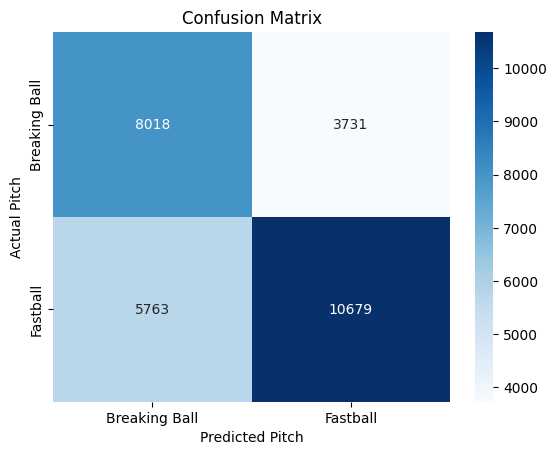

In [17]:
plt.title("Confusion Matrix")
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Breaking Ball', 'Fastball'], yticklabels=['Breaking Ball', 'Fastball'])
plt.xlabel('Predicted Pitch')
plt.ylabel('Actual Pitch')
plt.show()

ROC Curve

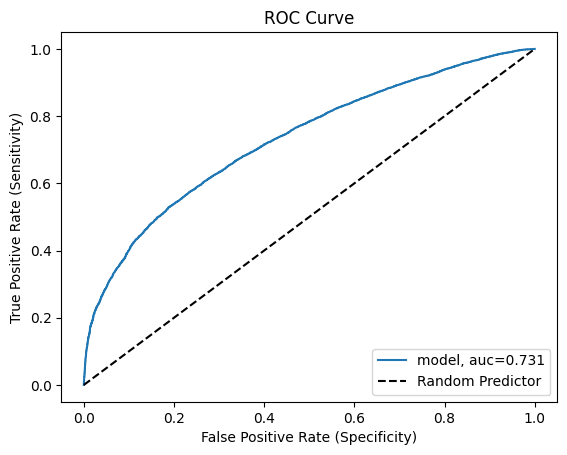

In [18]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="model, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Predictor')
plt.legend(loc=4)
plt.title("ROC Curve")
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

Calibration

In [19]:
result_df['prob_bin'] = pd.cut(result_df['pred_prob'], np.linspace(0, 1, 11))

C:\Users\johng\AppData\Local\Temp\ipykernel_32940\2295090214.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = result_df.groupby('prob_bin').agg(


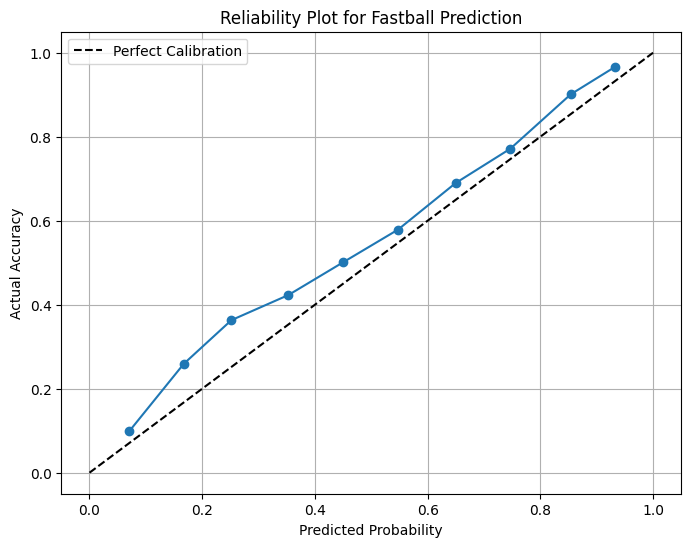

In [20]:
bin_summary = result_df.groupby('prob_bin').agg(
    avg_pred_prob=('pred_prob', 'mean'),  
    actual_accuracy=('pitch_type', 'mean') 
).dropna() 
plt.figure(figsize=(8, 6))
plt.plot(bin_summary['avg_pred_prob'], bin_summary['actual_accuracy'], marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

plt.xlabel('Predicted Probability')
plt.ylabel('Actual Accuracy')
plt.title('Reliability Plot for Fastball Prediction')
plt.legend()
plt.grid()
plt.show()

In [ ]:
bin_summary

,avg_pred_prob,actual_accuracy
prob_bin,,
"(0.0, 0.1]",0.585124,0.579545
"(0.1, 0.2]",0.582798,0.601423
"(0.2, 0.3]",0.575791,0.598244
"(0.3, 0.4]",0.565819,0.584771
"(0.4, 0.5]",0.562754,0.589054
"(0.5, 0.6]",0.554746,0.586375
"(0.6, 0.7]",0.561039,0.590816
"(0.7, 0.8]",0.547713,0.568994
"(0.8, 0.9]",0.545670,0.569759


Final list

In [285]:
result_df.loc[result_df['pred_pitch'] == result_df['pitch_type'], 'correct'] = 1.0
result_df['correct'] = result_df['correct'].fillna(0.0)

In [21]:
result_df

,pitcher,const,Count_0_1,Count_0_2,Count_2_1,Count_1_0,Count_1_1,Count_1_2,Count_2_0,Count_2_2,Count_3_1,Count_3_0,pitcher_fb_rate_batter_count,pitcher_fb_rate_pitcher_count,batter_fb_rate_batter_count,batter_fb_rate_pitcher_count,pred_pitch,pitch_type,pred_prob,prob_bin
227,"Abreu, Bryan",1.0,0,0,0,0,0,0,0,0,0,0,0.659292,0.357818,0.804348,0.485294,0,0,0.421893,"(0.4, 0.5]"
228,"Abreu, Bryan",1.0,1,0,0,0,0,0,0,0,0,0,0.656388,0.357204,0.787234,0.479651,0,0,0.351815,"(0.3, 0.4]"
229,"Abreu, Bryan",1.0,0,0,0,0,1,0,0,0,0,0,0.653509,0.356592,0.770833,0.474138,0,0,0.349510,"(0.3, 0.4]"
230,"Abreu, Bryan",1.0,0,0,0,0,0,0,0,0,0,0,0.650655,0.355983,0.829787,0.477723,0,0,0.418194,"(0.4, 0.5]"
231,"Abreu, Bryan",1.0,0,0,0,0,0,0,0,0,0,0,0.652174,0.357082,0.821429,0.477941,0,1,0.417661,"(0.4, 0.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27122,"Wingenter, Trey",1.0,0,0,0,0,0,0,0,0,0,0,0.544304,0.538945,0.704225,0.606164,1,0,0.541235,"(0.5, 0.6]"
27123,"Wingenter, Trey",1.0,0,0,0,1,0,0,0,0,0,0,0.542017,0.536250,0.694444,0.597973,1,0,0.589915,"(0.5, 0.6]"
27124,"Wingenter, Trey",1.0,0,0,0,0,1,0,0,0,0,0,0.539749,0.533582,0.684932,0.590000,0,0,0.463464,"(0.4, 0.5]"
27125,"Wingenter, Trey",1.0,0,0,0,0,0,1,0,0,0,0,0.541667,0.439320,0.689189,0.583333,0,1,0.304864,"(0.3, 0.4]"


In [22]:
final_list = result_df.groupby('pitcher')['correct'].agg(['mean', 'count']).reset_index()

KeyError: 'Column not found: correct'

In [287]:
final_list_sample = final_list.loc[final_list['count'] > 75]

In [288]:
final_list_sample.set_index('pitcher')[['mean']].sort_values('mean').head(10)

,mean
pitcher,
"Adcock, Ty",0.513514
"Karinchak, James",0.525210
"Romano, Jordan",0.525773
"Herrin, Tim",0.536232
"Munoz, Andres",0.537037
"Rogers, Taylor",0.540000
"Sims, Lucas",0.540958
"Diaz, Alexis",0.547091
"Faucher, Calvin",0.563380


In [289]:
final_list_sample.set_index('pitcher')[['mean']].sort_values('mean', ascending=False).head(10)

,mean
pitcher,
"Alvarado, Jose",0.997881
"Hudson, Bryan",0.963415
"Ferguson, Caleb",0.956800
"Armstrong, Shawn",0.935574
"Koch, Matt",0.916096
"Adams, Austin",0.900826
"Stratton, Hunter",0.879310
"Jansen, Kenley",0.864458
"Doyle, Tommy",0.860795
